# Compare logistic regression models of TP53 mutation for a) covariates only and b) covariates with gene expression data to determine marginal gain using gene expression data 

In [1]:
import os
import urllib
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, Imputer, FunctionTransformer
from sklearn.feature_selection import SelectKBest
from statsmodels.robust.scale import mad
from sklearn_pandas import DataFrameMapper
from IPython.display import display
import gc

//anaconda/envs/cognoma-machine-learning/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
//anaconda/envs/cognoma-machine-learning/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
%matplotlib inline
plt.style.use('seaborn-notebook')

## Specify model configuration

In [3]:
# We're going to be building a 'TP53' classifier 
GENE = '7157' # TP53

*Here is some [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) regarding the classifier and hyperparameters*

*Here is some [information](https://ghr.nlm.nih.gov/gene/TP53) about TP53*

## Load Data

In [4]:
%%time
path = os.path.join('..', '..', 'download', 'covariates.tsv')
covariates = pd.read_table(path, index_col=0)
path = os.path.join('..', '..', 'download', 'expression-matrix.tsv.bz2')
expression = pd.read_table(path, index_col=0)

CPU times: user 3min 29s, sys: 6.37 s, total: 3min 36s
Wall time: 3min 40s


In [5]:
%%time
path = os.path.join('..','..','download', 'mutation-matrix.tsv.bz2')
Y = pd.read_table(path, index_col=0)

CPU times: user 1min 59s, sys: 5.56 s, total: 2min 5s
Wall time: 2min 7s


In [6]:
X = {}
X['a'] = covariates
X['b'] = pd.concat([covariates,expression], axis=1)
for k in ['a','b']:
    print(X[k].shape)

(7306, 70)
(7306, 20600)


In [7]:
# Which columns have NaN values? 
X['b'].head()

,age_diagnosed,days_survived,days_recurrence_free,acronym_ACC,acronym_BLCA,acronym_BRCA,acronym_CESC,acronym_CHOL,acronym_COAD,acronym_DLBC,...,100289341,100289635,100294720,100302401,100302640,100302650,100302692,100302736,100303453,100303728
sample_id,,,,,,,,,,,,,,,,,,,,,
TCGA-02-0047-01,78.0,448.0,NaN,0,0,0,0,0,0,0,...,6.58,8.76,0.000,4.68,4.49,3.66,5.27,4.50,0.000,6.38
TCGA-02-0055-01,62.0,76.0,NaN,0,0,0,0,0,0,0,...,6.02,8.11,0.000,5.56,5.54,6.66,5.37,7.79,0.000,5.16
TCGA-02-2483-01,43.0,466.0,NaN,0,0,0,0,0,0,0,...,7.84,8.98,0.508,4.86,2.50,3.24,4.38,4.36,2.030,5.05
TCGA-02-2485-01,53.0,470.0,NaN,0,0,0,0,0,0,0,...,5.37,8.83,0.000,4.26,3.26,7.05,3.93,6.52,0.965,6.64
TCGA-02-2486-01,64.0,493.0,NaN,0,0,0,0,0,0,0,...,6.08,7.84,0.000,4.67,5.41,4.92,4.89,6.08,3.580,4.80


In [8]:
y = Y[GENE]

In [9]:
# The Series now holds TP53 Mutation Status for each Sample
y.head(6)

sample_id
TCGA-02-0047-01    0
TCGA-02-0055-01    1
TCGA-02-2483-01    1
TCGA-02-2485-01    1
TCGA-02-2486-01    0
TCGA-04-1348-01    1
Name: 7157, dtype: int64

In [10]:
# Here are the percentage of tumors with NF1
y.value_counts(True)

0    0.645907
1    0.354093
Name: 7157, dtype: float64

## Set aside 10% of the data for testing

In [10]:
X_train = {}
X_test = {}
for k in ['a','b']:
    X_train[k], X_test[k], y_train, y_test = train_test_split(X[k], y, test_size=0.1, random_state=0)
    'Size: {:,} features, {:,} training samples, {:,} testing samples'.format(len(X[k].columns), 
                                                                              len(X_train[k]), len(X_test[k]))

## Median absolute deviation feature selection

In [11]:
def fs_mad(x, y):
    """    
    Get the median absolute deviation (MAD) for each column of x
    """
    scores = mad(x) 
    return scores, np.array([np.NaN]*len(scores))

## Define pipeline and Cross validation model fitting

In [153]:
# Parameter Sweep for Hyperparameters

def get_cols(X,col_num, feat_type):
    if feat_type=='expression': return X[:,col_num:]
    return  X[:,:col_num]

param_grid = {
    'classify__loss': ['log'],
    'classify__penalty': ['elasticnet'],
    'classify__alpha': [1], #10.0 ** np.linspace(-3, 1, 10),
    'classify__l1_ratio': [0.15],
}

expression_feats = Pipeline(steps=[
    ('dim_red', FunctionTransformer(get_cols,kw_args={'col_num':covariates.shape[1],'feat_type':'expression'})),
    ('select', SelectKBest(fs_mad,2000)),
])

covariate_feats = Pipeline(steps=[
    ('dim_red', FunctionTransformer(get_cols,kw_args={'col_num':covariates.shape[1],'feat_type':'covariates'}))
])

combo_pipeline = Pipeline([
    ('imputer', Imputer()),
    ('standardize', StandardScaler()),
    ('features', FeatureUnion([
        ('expression_feats', expression_feats),
        ('covariates_feats', covariate_feats),           
    ])),
    ('classify', SGDClassifier(random_state=0, class_weight='balanced'))
])

covariates_pipeline = Pipeline(steps=[
    ('imputer', Imputer()),
    ('standardize', StandardScaler()),
    ('select', SelectKBest(fs_mad,'all')),
    ('classify', SGDClassifier(random_state=0, class_weight='balanced'))
])

cv_pipeline = {}
cv_pipeline['a'] = GridSearchCV(estimator=covariates_pipeline, param_grid=param_grid, scoring='roc_auc')
cv_pipeline['b'] = GridSearchCV(estimator=combo_pipeline, param_grid=param_grid, scoring='roc_auc')

## Alternative pipeline with DataFrameMapper and Cross validation model fitting

In [151]:
# Parameter Sweep for Hyperparameters

param_grid = {
    'classify__loss': ['log'],
    'classify__penalty': ['elasticnet'],
    'classify__alpha': [1], #10.0 ** np.linspace(-3, 1, 10),
    'classify__l1_ratio': [0.15],
}

combo_pipeline = Pipeline([
    ('select', DataFrameMapper([ # must keep select first
                    (list(expression.columns.values), SelectKBest(fs_mad,2000)),
                    (list(covariates.columns.values), SelectKBest('all'))
                ])),
    ('imputer', Imputer()),
    ('standardize', StandardScaler()),
    ('classify', SGDClassifier(random_state=0, class_weight='balanced'))
])

covariates_pipeline = Pipeline(steps=[
    ('imputer', Imputer()),
    ('standardize', StandardScaler()),
    ('select', SelectKBest(fs_mad,'all')),
    ('classify', SGDClassifier(random_state=0, class_weight='balanced'))
])

cv_pipeline = {}
cv_pipeline['a'] = GridSearchCV(estimator=covariates_pipeline, param_grid=param_grid, scoring='roc_auc')
cv_pipeline['b'] = GridSearchCV(estimator=combo_pipeline, param_grid=param_grid, scoring='roc_auc')

In [154]:
#%%time
# Train model a.
cv_pipeline['a'].fit(X=X_train['a'], y=y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('select', SelectKBest(k='all', score_func=<function fs_mad at 0x159c6e620>)), ('classify', SGDClassifier(alpha=0.0001, average...      penalty='l2', power_t=0.5, random_state=0, shuffle=True, verbose=0,
       warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'classify__alpha': [1], 'classify__l1_ratio': [0.15], 'classify__penalty': ['elasticnet'], 'classify__loss': ['log']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [155]:
%%time
# Train model b.
cv_pipeline['b'].fit(X=X_train['b'].iloc[0:100], y=y_train.iloc[0:100])

CPU times: user 1.77 s, sys: 251 ms, total: 2.02 s
Wall time: 1.17 s


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('features', FeatureUnion(n_jobs=1,
       transformer_list=[('select', Pipeline(steps=[('dim_red', FunctionTransformer(accept_...      penalty='l2', power_t=0.5, random_state=0, shuffle=True, verbose=0,
       warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'classify__alpha': [1], 'classify__l1_ratio': [0.15], 'classify__penalty': ['elasticnet'], 'classify__loss': ['log']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [156]:
# Best Params
for k in ['a','b']:
    print('{:.3%}'.format(cv_pipeline[k].best_score_))
    print(cv_pipeline[k].best_params_)

57.270%
{'classify__alpha': 1, 'classify__l1_ratio': 0.15, 'classify__penalty': 'elasticnet', 'classify__loss': 'log'}
76.841%
{'classify__alpha': 1, 'classify__l1_ratio': 0.15, 'classify__penalty': 'elasticnet', 'classify__loss': 'log'}


## Visualize hyperparameters performance

In [157]:
cv_result_df = {}
for k in ['a','b']:
    cv_result_df[k] = pd.concat([
        pd.DataFrame(cv_pipeline[k].cv_results_),
        pd.DataFrame.from_records(cv_pipeline[k].cv_results_['params']),
    ], axis='columns')
    display(cv_result_df[k].head(2))

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_classify__alpha,param_classify__l1_ratio,param_classify__loss,param_classify__penalty,params,rank_test_score,...,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score,classify__alpha,classify__l1_ratio,classify__loss,classify__penalty
0,0.061903,0.006933,0.572704,0.573641,1,0.15,log,elasticnet,"{'classify__alpha': 1, 'classify__l1_ratio': 0...",1,...,0.5,0.5,0.004735,0.000332,0.102773,0.104144,1,0.15,log,elasticnet


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_classify__alpha,param_classify__l1_ratio,param_classify__loss,param_classify__penalty,params,rank_test_score,...,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score,classify__alpha,classify__l1_ratio,classify__loss,classify__penalty
0,0.203273,0.031351,0.768409,0.955698,1,0.15,log,elasticnet,"{'classify__alpha': 1, 'classify__l1_ratio': 0...",1,...,0.644628,0.986166,0.00979,0.001347,0.094669,0.027038,1,0.15,log,elasticnet


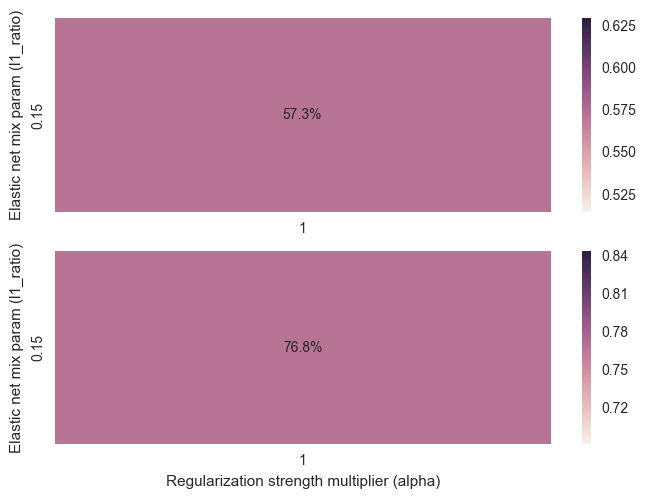

In [158]:
# Cross-validated performance heatmap
for i,k in enumerate(['a','b']):
    ax = plt.subplot(2,1,i+1)
    cv_score_mat = pd.pivot_table(cv_result_df[k], values='mean_test_score', index='classify__l1_ratio', columns='classify__alpha')

    ax = sns.heatmap(cv_score_mat, annot=True, fmt='.1%')
    if i == 1: ax.set_xlabel('Regularization strength multiplier (alpha)')
    else: ax.set_xlabel('')
    ax.set_ylabel('Elastic net mix param (l1_ratio)');

## Use Optimal Hyperparameters to Output ROC Curve

In [159]:
def get_threshold_metrics(y_true, y_pred):
    roc_columns = ['fpr', 'tpr', 'threshold']
    roc_items = zip(roc_columns, roc_curve(y_true, y_pred))
    roc_df = pd.DataFrame.from_items(roc_items)
    auroc = roc_auc_score(y_true, y_pred)
    return {'auroc': auroc, 'roc_df': roc_df}

y_pred_train = {}
y_pred_test = {}
metrics_train = {}
metrics_test = {}
for k in ['a','b']:
    y_pred_train[k] = cv_pipeline[k].decision_function(X_train[k])
    y_pred_test[k] = cv_pipeline[k].decision_function(X_test[k])

    metrics_train[k] = get_threshold_metrics(y_train, y_pred_train[k])
    metrics_test[k] = get_threshold_metrics(y_test, y_pred_test[k])

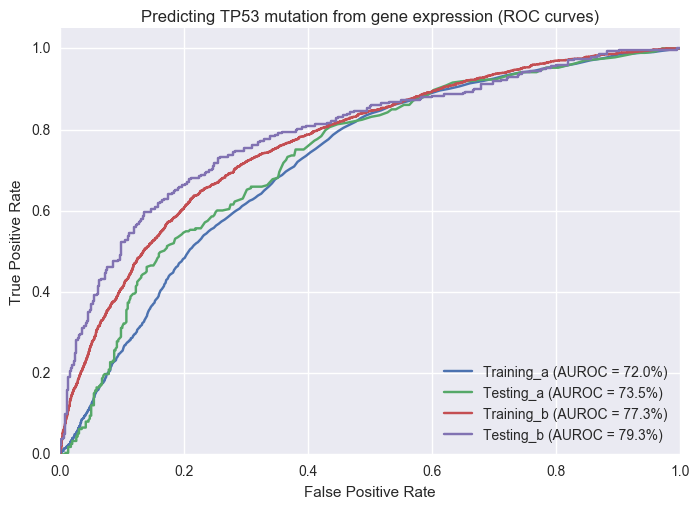

In [160]:
# Plot ROC
for i,k in enumerate(['a','b']):
    for label, metrics in ('Training', metrics_train[k]), ('Testing', metrics_test[k]):
        roc_df = metrics['roc_df']
        plt.plot(roc_df.fpr, roc_df.tpr,
            label='{} (AUROC = {:.1%})'.format(label+'_'+str(k), metrics['auroc']))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Predicting TP53 mutation from gene expression (ROC curves)')
    plt.legend(loc='lower right');

## What are the classifier coefficients?

In [162]:
final_pipeline = {}
final_classifier = {}
for k in ['a','b']:
    final_pipeline[k] = cv_pipeline[k].best_estimator_
    final_classifier[k] = final_pipeline[k].named_steps['classify']

In [197]:
coef_df = {}
for k in ['a','b']:
    
    if k == 'a': select_step = 'select'
    else: select_step = 'features'
    
    select_indices = final_pipeline[k].named_steps[select_step].transform(
        np.arange(len(X[k].columns)).reshape(1, -1)
    ).tolist()
    
    if k=='b': select_indices = [x for sublist in select_indices for x in sublist]

    coef_df[k] = pd.DataFrame.from_items([
        ('feature', X[k].columns[select_indices]),
        ('weight', final_classifier[k].coef_[0]),
    ])

    coef_df[k]['abs'] = coef_df[k]['weight'].abs()
    coef_df[k] = coef_df[k].sort_values('abs', ascending=False)
    
    # add positive and negatives to dataframe
    coef_df[k]['positives'] = coef_df[k].weight > 0
    coef_df[k]['negatives'] = coef_df[k].weight < 0

In [198]:
for k in ['a','b']:
    print('{:.1%} zero coefficients; {:,} negative and {:,} positive coefficients'.format(
            (coef_df[k].weight == 0).mean(),
            ().sum(),
            (coef_df[k].weight > 0).sum()
    ))

98.6% zero coefficients; 0 negative and 1 positive coefficients
99.3% zero coefficients; 3 negative and 12 positive coefficients


In [199]:
# What are the top weighted features for model a and model b?
display(coef_df['b'].head(5))
display(coef_df['a'].head(5))

,feature,weight,abs
1087,55316,-0.065449,0.065449
1870,389336,0.062481,0.062481
1374,84002,0.042808,0.042808
425,5653,0.031213,0.031213
509,6732,0.030229,0.030229


,feature,weight,abs
69,n_mutations_log1p,0.028788,0.028788
44,organ_Eye,0.000000,0.000000
50,organ_Lymphatic tissue,0.000000,0.000000
49,organ_Lung,0.000000,0.000000
48,organ_Liver,0.000000,0.000000


In [201]:
# What are the model a features in model b?
def RepresentsInt(s):
    try: 
        int(s)
        return True
    except ValueError:
        return False

coef_df['b']['isFeatureFromA'] = [not RepresentsInt(x) for x in coef_df['b']['feature']]
display(coef_df['b'].query('isFeatureFromA').head())
print('rank of model a features in model b:', np.flatnonzero(coef_df['b']['isFeatureFromA']))

,feature,weight,abs,isFeatureFromA
2036,organ_Bile duct,0.0,0.0,True
2035,organ_Adrenal gland,0.0,0.0,True
2034,acronym_UVM,0.0,0.0,True
2033,acronym_UCS,0.0,0.0,True
2032,acronym_UCEC,0.0,0.0,True


rank of model a features in model b: [ 655  656  657  658  659  660  661  662  663  664  665  666  667  668  669
  670  671  672  673  674  675  676  677  678  679  680  681  682  683  684
  685  686  687  688  689  690  691  692  693  694  695  696  697  698  699
  700  701  702  703  704  705  706  707  708  709  710  711  712  713  714
  715  716  717  718  750  752  753  754  755 2069]


## Investigate the predictions

In [268]:
predict_df = {}
for k in ['a','b']:
    predict_df[k] = pd.DataFrame.from_items([
        ('sample_id', X[k].index),
        ('testing', X[k].index.isin(X_test[k].index).astype(int)),
        ('status', y),
        ('decision_function', cv_pipeline[k].decision_function(X[k])),
        ('probability', cv_pipeline[k].predict_proba(X[k])[:, 1]),
    ])
    predict_df[k]['probability_str'] = predict_df[k]['probability'].apply('{:.1%}'.format)

In [269]:
# Top predictions amongst negatives (potential hidden responders)
for k in ['a','b']:
    display(predict_df[k].sort_values('decision_function', ascending=False).query("status == 0").head(5))

,sample_id,testing,status,decision_function,probability,probability_str
sample_id,,,,,,
TCGA-IB-7651-01,TCGA-IB-7651-01,0,0,5.044342,0.993596,99.4%
TCGA-L5-A4OI-01,TCGA-L5-A4OI-01,1,0,3.889747,0.979959,98.0%
TCGA-L5-A8NM-01,TCGA-L5-A8NM-01,0,0,3.714916,0.976222,97.6%
TCGA-N7-A4Y0-01,TCGA-N7-A4Y0-01,0,0,3.321973,0.965175,96.5%
TCGA-CA-6717-01,TCGA-CA-6717-01,1,0,2.885321,0.947116,94.7%


,sample_id,testing,status,decision_function,probability,probability_str
sample_id,,,,,,
TCGA-L5-A4OH-01,TCGA-L5-A4OH-01,0,0,4.922734,0.992773,99.3%
TCGA-L5-A8NR-01,TCGA-L5-A8NR-01,0,0,4.885036,0.992498,99.2%
TCGA-09-2051-01,TCGA-09-2051-01,0,0,4.870500,0.992389,99.2%
TCGA-B6-A0I6-01,TCGA-B6-A0I6-01,1,0,4.567853,0.989726,99.0%
TCGA-55-6981-01,TCGA-55-6981-01,0,0,4.275788,0.986289,98.6%


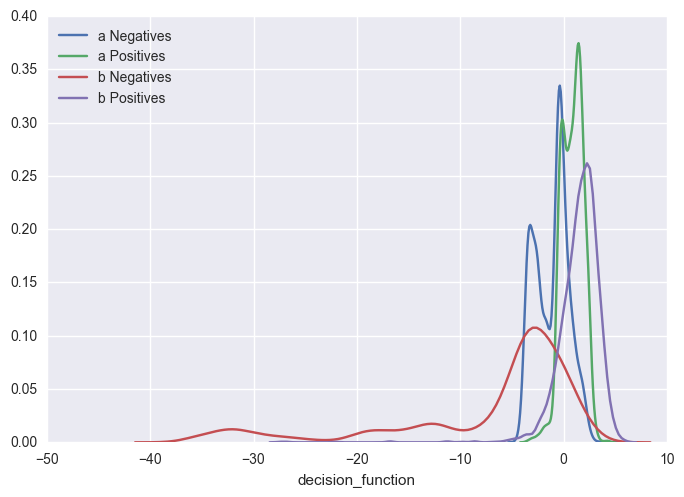

In [276]:
# Ignore numpy warning caused by seaborn
warnings.filterwarnings('ignore', 'using a non-integer number instead of an integer')
for k in ['a','b']:
    ax = sns.distplot(predict_df[k].query("status == 0").decision_function, hist=False, label=k+' Negatives')
    ax = sns.distplot(predict_df[k].query("status == 1").decision_function, hist=False, label=k+' Positives')

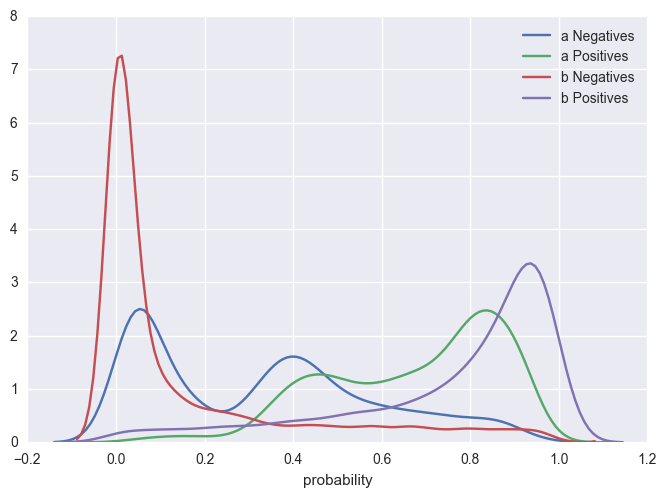

In [277]:
for k in ['a','b']:
    ax = sns.distplot(predict_df[k].query("status == 0").probability, hist=False, label=k+' Negatives')
    ax = sns.distplot(predict_df[k].query("status == 1").probability, hist=False, label=k+' Positives')